<a href="https://colab.research.google.com/github/jess-es02/CASA0005/blob/main/AssessmentNetworks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Urban Simulation Assessment: Networks**

To note for the write-up:
* Problems with the provided tube network - missing Circle, Met, or Hammersmith & City lines in situations where there is overlap
* Time-band chosen is AM-peak (7-10am) - same as practical
* Battersea Power Station, Battersea Park, and Nine Elms excluded (even for topological section) because we don't have flow data
* Crossrail removed for both sections - this removed 11 nodes and 13 edges
* No transfer penalties
* Flow data assumes passengers take the shortest path
* Note that degree doesn't mean number of lines, but simply number of adjacent stops
* See walking time assumptions, e.g. Liu *et al.* (2023) 1.4m/s for someone non-disabled, plus assumptions of minutes per stop (no transfer penalties)
* GTFS Schedule data would improve things

## Set Up Environment

In [1]:
#Install osmnx - as my laptop is broken, I am working in Google Colab rather than the recommended Anaconda environment
!pip install osmnx openpyxl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.9/99.9 kB 1.8 MB/s eta 0:00:00


In [2]:
#Import necessary libraries
import pandas as pd
import numpy as np
import geopandas as gpd
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import json
import re
import osmnx as ox
import folium
import pickle
from shapely.geometry import Point, LineString
from scipy.spatial import distance

## Set Up Tube Network

In [3]:
#ChatGPT helped with loading the pkl file
file_path = 'London_tube_network_cl.pkl'
with open(file_path, 'rb') as f:
    G = pickle.load(f)

print(G)
print(type(G))

Graph with 401 nodes and 467 edges
<class 'networkx.classes.graph.Graph'>


In [4]:
#Checking node attributes
list(G.nodes(data = True))[0]

('Edgware', {'coords': (519497.64608500665, 191981.34593468817)})

In [5]:
#Checking edge attributes
list(G.edges(data = True))[0]

('Edgware',
 'Burnt Oak',
 {'length': 1518.1144792538078, 'line_name': 'Northern'})

In [6]:
#It might be useful to add line data to the nodes

for o, d, edge_dict in G.edges(data=True):
  #Extract the edge's line
  line_name = edge_dict['line_name']

  #Add the line to both nodes' attributes, assuming it has not already been added
  if 'lines' not in G.nodes[o]:
    G.nodes[o]['lines'] = [line_name]
  else:
    if line_name not in G.nodes[o]['lines']:
      G.nodes[o]['lines'].append(line_name)

  if 'lines' not in G.nodes[d]:
    G.nodes[d]['lines'] = [line_name]
  else:
    if line_name not in G.nodes[d]['lines']:
      G.nodes[d]['lines'].append(line_name)

In [7]:
#Checking node attributes - looks good
list(G.nodes(data = True))[0]

('Edgware',
 {'coords': (519497.64608500665, 191981.34593468817), 'lines': ['Northern']})

In [8]:
# List of nodes missing the 'lines' attribute
missing_lines = [node for node in G.nodes() if 'lines' not in G.nodes[node]]
missing_lines
#All nodes have the "lines" attribute attached

[]

In [9]:
print(G.nodes["Stratford"]) #Looks like some Metropolitan and Hammersmith & City edge data is missing - potentially causing misleading degrees or shortest paths!

{'coords': (538522.8800296986, 184373.09655329626), 'lines': ['TfL Rail', 'Central', 'Jubilee', 'London Overground', 'DLR']}


In [10]:
#Reminder of the nodes and edges
print(G)

Graph with 401 nodes and 467 edges


In [11]:
#We need to remove all edges which just have Crossrail
G.remove_edges_from([(u, v) for u, v, data in G.edges(data=True)
                     if 'line_name' in data and
                     (('TfL Rail' in data['line_name']) if isinstance(data['line_name'], list) else data['line_name'] == 'TfL Rail')])

In [12]:
print(G) #13 edges removed - looks good

Graph with 401 nodes and 454 edges


In [44]:
#We also need to remove all nodes which just have Crossrail

crossrail_only_nodes = [node for node, data in G.nodes(data=True) if 'lines' in data and data['lines'] == ['TfL Rail']]
G.remove_nodes_from(crossrail_only_nodes)

In [14]:
print(G) #11 nodes removed

Graph with 390 nodes and 454 edges


In [15]:
#If any nodes still contain Tfl Rail, remove it from these nodes
for node, data in G.nodes(data=True):
    if 'lines' in data and 'TfL Rail' in data['lines']:
        data['lines'].remove('TfL Rail')

print(G)

Graph with 390 nodes and 454 edges


In [16]:
#Do any edges contain TfL Rail?
for u, v, data in G.edges(data=True):
    if 'line_name' in data and 'TfL Rail' in data['line_name']:
        print(u, v, data)
#TfL Rail has been removed

In [17]:
#Loading in passenger flow data - this section was mostly taken from Practical 5
files = ['NBT19MTT2b_od__DLR_tb_wf.csv',
         'NBT19MTT2b_od__EZL_tb_wf.csv',
         'NBT19MTT2b_od__LO_tb_wf.csv',
         'NBT19MTT2b_od__LU_tb_wf.csv']

#Create an empty list to store dataframes for each file
dfs = []

#Iterate through our files list, read the file and append to our dataframe list
for file in files:
    dfs.append(pd.read_csv(file))

#Merge all dataframes
london_OD = pd.concat(dfs, ignore_index=True)

london_OD.head()

,mode_mnlc_o,mode_mnlc_d,2,3,4,5,6,7,mode,1,8
0,504,523,8.033,16.430,24.563,28.555,13.023,2.263,DLR,NaN,NaN
1,504,533,30.719,40.105,61.571,57.881,15.573,0.317,DLR,NaN,NaN
2,504,538,5.941,17.238,37.493,43.158,33.890,10.429,DLR,NaN,NaN
3,504,559,5.795,26.397,27.285,24.065,15.213,8.508,DLR,NaN,NaN
4,504,573,77.786,113.750,143.938,387.562,165.776,65.283,DLR,NaN,NaN


In [18]:
#Reading in the definitions file to match station codes to names
definition_df = pd.read_excel('NBT19_Definitions.xlsx', 'Stations')
definition_df.head()

,MNLC,MASC,StationName,TFL?
0,500.0,ACTu,Acton Town,True
1,501.0,BARu,Barbican,True
2,502.0,ALDu,Aldgate,True
3,503.0,ALEu,Aldgate East,True
4,504.0,STId,Stratford International DLR,True


In [19]:
#Dropping any missing values
definition_df.dropna(inplace=True)

#Transform codes into integers
definition_df.MNLC = definition_df.MNLC.astype(int)
definition_df.head()

,MNLC,MASC,StationName,TFL?
0,500,ACTu,Acton Town,True
1,501,BARu,Barbican,True
2,502,ALDu,Aldgate,True
3,503,ALEu,Aldgate East,True
4,504,STId,Stratford International DLR,True


In [20]:
#Add the station names to the flows dataframe
london_OD['station_origin'] = london_OD['mode_mnlc_o'].apply(lambda x: definition_df[definition_df.MNLC==x]['StationName'].values[0])
london_OD['station_destination'] = london_OD['mode_mnlc_d'].apply(lambda x: definition_df[definition_df.MNLC==x]['StationName'].values[0])
london_OD.head()

,mode_mnlc_o,mode_mnlc_d,2,3,4,5,6,7,mode,1,8,station_origin,station_destination
0,504,523,8.033,16.430,24.563,28.555,13.023,2.263,DLR,NaN,NaN,Stratford International DLR,King George V
1,504,533,30.719,40.105,61.571,57.881,15.573,0.317,DLR,NaN,NaN,Stratford International DLR,London City Airport
2,504,538,5.941,17.238,37.493,43.158,33.890,10.429,DLR,NaN,NaN,Stratford International DLR,Pontoon Dock
3,504,559,5.795,26.397,27.285,24.065,15.213,8.508,DLR,NaN,NaN,Stratford International DLR,West Silvertown
4,504,573,77.786,113.750,143.938,387.562,165.776,65.283,DLR,NaN,NaN,Stratford International DLR,Woolwich Arsenal


In [21]:
#Only keeping flows for the timeband of interest - in this instance, AM peak (7-10am)
london_OD_AMpeak = london_OD[['station_origin', 'station_destination', '3']].copy()
london_OD_AMpeak.rename({'3':'flows'}, axis=1, inplace=True)
london_OD_AMpeak.flows = london_OD_AMpeak.flows.astype(int)
london_OD_AMpeak.head()

,station_origin,station_destination,flows
0,Stratford International DLR,King George V,16
1,Stratford International DLR,London City Airport,40
2,Stratford International DLR,Pontoon Dock,17
3,Stratford International DLR,West Silvertown,26
4,Stratford International DLR,Woolwich Arsenal,113


In [22]:
#Examining station names
station_origin = list(london_OD_AMpeak.station_origin.values)
station_destination = list(london_OD_AMpeak.station_destination.values)
all_stations = list(set(station_origin + station_destination))
all_stations = sorted(all_stations, key=str.lower)

In [23]:
london_OD_AMpeak['station_origin']= london_OD_AMpeak.station_origin.apply(lambda x:
                                      re.sub('\sLU\s?|\sLO\s?|\sNR\s?|\sTf[lL]\s?|\sDLR\s?|\s\(.*\)', '', x)
                                     )
london_OD_AMpeak['station_destination']=london_OD_AMpeak.station_destination.apply(lambda x:
                                      re.sub('\sLU\s?|\sLO\s?|\sNR\s?|\sTf[lL]\s?|\sDLR\s?|\s\(.*\)', '', x)
                                     )

In [24]:
london_OD_AMpeak = london_OD_AMpeak.groupby(['station_origin', 'station_destination'], as_index=False).sum()

In [25]:
#Now we have the OD data and network data, let's check their names match
OD_names = set(london_OD_AMpeak.station_origin.unique())
network_names = set([n for n in G.nodes()])
network_names.symmetric_difference(OD_names)

{'Acton Main Line',
 'Battersea Power Station',
 'Brentwood',
 'Chadwell Heath',
 'Forest Gate',
 'Gidea Park',
 'Goodmayes',
 'Hanwell',
 'Harold Wood',
 'Hayes & Harlington',
 'Heathrow Terminal 4 EL',
 'Heathrow Terminals 123',
 'Heathrow Terminals 2 & 3',
 'Heathrow Terminals 2 & 3 EL',
 'Ilford',
 'Manor Park',
 'Maryland',
 'Nine Elms',
 'Seven Kings',
 'Shenfield',
 'Southall',
 "Walthamstow Queen's Road",
 'Walthamstow Queens Road',
 'West Ealing'}

In [26]:
#Create a mapping for the stations we are keeping
#Removing Northern Line stations which opened after flow data
#Alongside Crossrail stations, which are being excluded from the analysis

name_map = {
    'Heathrow Terminal 4 EL': 'Heathrow Terminal 4',
    'Heathrow Terminals 123': 'Heathrow Terminals 2 & 3',
    'Heathrow Terminals 2 & 3 EL': 'Heathrow Terminals 2 & 3',
    "Walthamstow Queen's Road": 'Walthamstow Queens Road'}

london_OD_AMpeak.station_origin = london_OD_AMpeak.station_origin.apply(
    lambda x: name_map[x] if x in name_map.keys() else x)
london_OD_AMpeak.station_destination = london_OD_AMpeak.station_destination.apply(
    lambda x: name_map[x] if x in name_map.keys() else x)

In [27]:
#let's filter out the stations that we don't have in our network
OD_names = set(london_OD_AMpeak.station_origin.unique())
_filter = list(network_names.symmetric_difference(OD_names))
_filter

['Hanwell',
 'Hayes & Harlington',
 'Battersea Power Station',
 'Shenfield',
 'Manor Park',
 'Harold Wood',
 'Acton Main Line',
 'Chadwell Heath',
 'West Ealing',
 'Nine Elms',
 'Gidea Park',
 'Ilford',
 'Southall',
 'Seven Kings',
 'Forest Gate',
 'Goodmayes',
 'Maryland',
 'Brentwood']

In [28]:
london_OD_AMpeak = london_OD_AMpeak[~london_OD_AMpeak.station_origin.isin(_filter)]
london_OD_AMpeak = london_OD_AMpeak[~london_OD_AMpeak.station_destination.isin(_filter)]

In [29]:
#Add the data for OD pairs, assuming individuals take the shortest path

#Create a dictionary to store flows for all edges
flows = {(u,v): 0 for u,v in G.edges()}

#Calculate shortest paths for all flows and add data to dict
for i, row in london_OD_AMpeak.iterrows():
    source = row.station_origin
    target = row.station_destination

    #Get shortest path
    path = nx.dijkstra_path(G, source, target)

    #Our path is a list of nodes, we need to turn this to a list of edges
    path_edges = list(zip(path,path[1:]))

    #Add flows to our dict
    for u,v in path_edges:
        try:
            flows[(u,v)] += row.flows
        except:
            flows[(v,u)] += row.flows

In [30]:
#Set this as a network attribute
nx.set_edge_attributes(G, flows, 'flows')

In [31]:
#Find all edges where flows is 0
zero_flows = [e for e in G.edges(data=True) if e[2]['flows'] == 0]
zero_flows

[('Kennington',
  'Nine Elms',
  {'length': 2030.5945008714068, 'line_name': 'Northern', 'flows': 0}),
 ('Battersea Power Station',
  'Nine Elms',
  {'length': 1073.4483640139013, 'line_name': 'Northern', 'flows': 0}),
 ('Wandsworth Road',
  'Battersea Park',
  {'length': 1168.465610239016, 'line_name': 'London Overground', 'flows': 0})]

In [32]:
#Remove these edges
G.remove_edges_from(zero_flows)

In [33]:
#Remove Battersea Power Station, Nine Elms, and Battersea Park from nodes
G.remove_node('Battersea Power Station')
G.remove_node('Nine Elms')
G.remove_node('Battersea Park')

In [34]:
print(G)

Graph with 387 nodes and 451 edges


In [35]:
#Add inverse flows
inverse_flows = {(u,v): 1/flows[(u,v)] for u,v in G.edges()}
nx.set_edge_attributes(G, inverse_flows, 'inverse_flows')

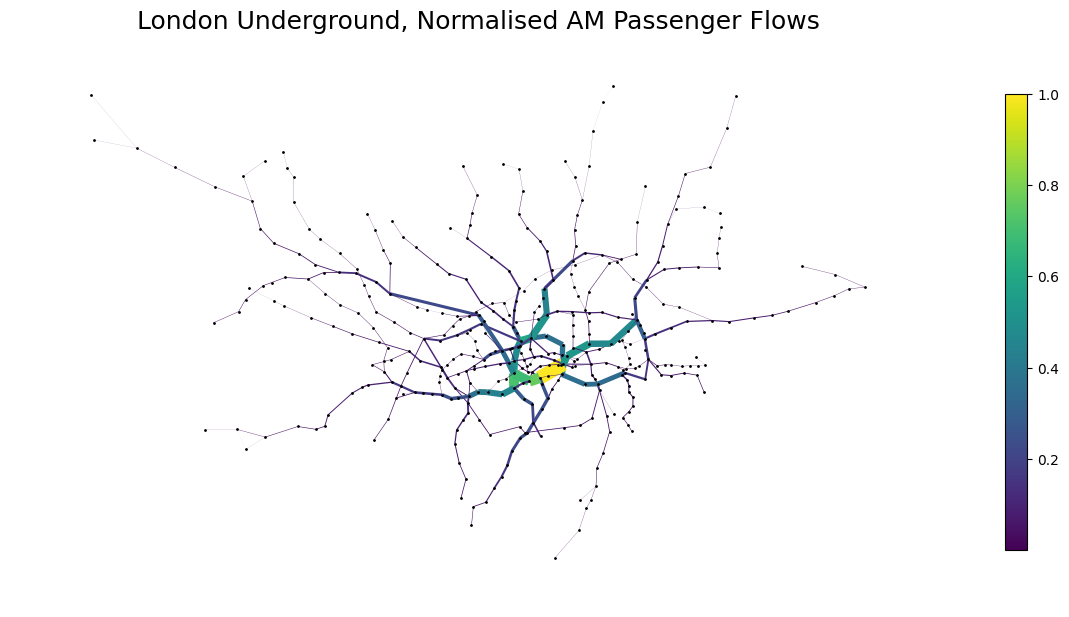

In [36]:
#Plot our calculated flows
flows_values = flows.values()
flow_color=[(i[2]['flows']/max(flows_values)) for i in G.edges(data=True)]
flow_width=[(i[2]['flows']/max(flows_values)*10) for i in G.edges(data=True)]

# Plot graph
fig, ax = plt.subplots(figsize=(12,6))

pos = {node: data['coords'] for node, data in G.nodes(data=True)}
edg=nx.draw_networkx_edges(G,pos, edge_color=flow_color, width=flow_width)

nx.draw_networkx_nodes(G,
        pos = pos,
        node_color= 'black',
        node_size= 1)

plt.tight_layout()
plt.colorbar(edg,orientation="vertical", shrink=0.8)
plt.axis("off")
plt.title("London Underground, Normalised AM Passenger Flows",fontsize=18)
plt.show()

## Computing Centrality Measures

### Degree Centrality

In [37]:
#Let's calculate topological degree and normalised topological degree centrality, and add them as node attributes
top_degree = nx.degree(G)
nx.set_node_attributes(G,dict(top_degree),'top_degree')

top_degree_norm = nx.degree_centrality(G)
nx.set_node_attributes(G,dict(top_degree_norm),'top_degree_norm')

### Eigenvector Centrality

In [38]:
top_eigen = nx.eigenvector_centrality(G, max_iter=10000)
nx.set_node_attributes(G,dict(top_eigen),'top_eigen')

### Betweenness Centrality

In [39]:
top_between = nx.betweenness_centrality(G)
nx.set_node_attributes(G,dict(top_between),'top_between')

### Top 10

In [40]:
df = pd.DataFrame(index=G.nodes())
df['top_degree'] = pd.Series(nx.get_node_attributes(G, 'top_degree'))
df['top_degree_norm'] = pd.Series(nx.get_node_attributes(G, 'top_degree_norm'))
df['top_eigen'] = pd.Series(nx.get_node_attributes(G, 'top_eigen'))
df['top_between'] = pd.Series(nx.get_node_attributes(G, 'top_between'))

In [43]:
#Get top 10 by degree/normalised degree
df_sorted_deg = df.sort_values('top_degree', ascending=False)
df_sorted_deg.head(10)

#Note that this looks misleading, due to missing stations!
#It had originally been Stratford before I removed Crossrail
#And Kings X should be top, but some lines are weirdly excluded

,top_degree,top_degree_norm,top_eigen,top_between
Bank and Monument,8,0.020725,0.279694,0.247692
Baker Street,7,0.018135,0.180244,0.193136
Stratford,7,0.018135,0.015143,0.199081
King's Cross St. Pancras,7,0.018135,0.059045,0.254118
Earl's Court,6,0.015544,0.006350,0.119677
Waterloo,6,0.015544,0.246510,0.209823
West Ham,6,0.015544,0.009383,0.113650
Green Park,6,0.015544,0.338128,0.197236
Oxford Circus,6,0.015544,0.334507,0.057178
Canning Town,6,0.015544,0.005777,0.100563


In [ ]:
#Get top 10 by eigenvector
df_sorted_eigen = df.sort_values('top_eigen', ascending=False)
df_sorted_eigen.head(10)

,top_degree,top_degree_norm,top_eigen,top_between
Green Park,6,0.015544,0.338128,0.197236
Oxford Circus,6,0.015544,0.334507,0.057178
Bank and Monument,8,0.020725,0.279694,0.247692
Piccadilly Circus,4,0.010363,0.263926,0.006390
Waterloo,6,0.015544,0.246510,0.209823
Bond Street,4,0.010363,0.240797,0.133579
Westminster,4,0.010363,0.224111,0.175895
Baker Street,7,0.018135,0.180244,0.193136
Embankment,4,0.010363,0.178956,0.013739
Tottenham Court Road,4,0.010363,0.176231,0.009095


In [ ]:
#Get top 10 by betweenness
df_sorted_betw = df.sort_values('top_between', ascending=False)
df_sorted_betw.head(10)

,top_degree,top_degree_norm,top_eigen,top_between
King's Cross St. Pancras,7,0.018135,0.059045,0.254118
Bank and Monument,8,0.020725,0.279694,0.247692
Euston,5,0.012953,0.067177,0.216404
Waterloo,6,0.015544,0.246510,0.209823
Stratford,7,0.018135,0.015143,0.199081
Green Park,6,0.015544,0.338128,0.197236
Highbury & Islington,4,0.010363,0.020607,0.196544
Baker Street,7,0.018135,0.180244,0.193136
Westminster,4,0.010363,0.224111,0.175895
Finchley Road,4,0.010363,0.067391,0.168556


## Node Removal

## Degree

In [ ]:
#Define function to find size of LCC
def lcc_size(G):
    return len(max(nx.connected_components(G), key=len))

In [ ]:
G_deg_rem = G.copy()

#Set up initial variables
start_lcc = lcc_size(G)
stations_removed = 0
station_removed = 'N/A'
proportion_lcc = 100
num_components = nx.number_connected_components(G)

removed_nodes = []
removed_edges = []

#Initialise dataframe
col_names = ['stations_removed', 'station_removed', 'num_components', 'size_of_lcc', 'proportion_lcc']
results_deg = pd.DataFrame(columns=col_names)
results_deg.loc[0] = [stations_removed, station_removed, num_components, start_lcc, proportion_lcc]

#Sequentially remove nodes based on degree centrality:
for i in range(10):
  #Calculate degree centrality:
  degree_centrality = nx.degree_centrality(G_deg_rem)
  nx.set_node_attributes(G_deg_rem, degree_centrality, 'degree_centrality')
  df = pd.DataFrame(index=G_deg_rem.nodes())
  df['degree_centrality'] = pd.Series(nx.get_node_attributes(G_deg_rem, 'degree_centrality'))
  df_sorted = df.sort_values(["degree_centrality"], ascending=False)

  #Find station with the highest centrality
  row = df_sorted.iloc[0]
  node_to_remove = row.name
  #Store nodes and edges for plotting
  removed_nodes.append(node_to_remove)
  removed_edges.extend(list(G_deg_rem.edges(node_to_remove)))
  G_deg_rem.remove_node(node_to_remove)

  #Calculate metrics
  stations_removed += 1
  station_removed = node_to_remove
  num_components= nx.number_connected_components(G_deg_rem)
  size_of_lcc = lcc_size(G_deg_rem)
  current_size = G_deg_rem.number_of_nodes()
  proportion_lcc = round(size_of_lcc / current_size * 100, 2)

  #Add to dataframe
  results_deg.loc[i+1] = [stations_removed, station_removed, num_components, size_of_lcc, proportion_lcc]

results_deg

,stations_removed,station_removed,num_components,size_of_lcc,proportion_lcc
0,0,N/A,1,387,100.00
1,1,Bank and Monument,1,386,100.00
2,2,Baker Street,1,385,100.00
3,3,King's Cross St. Pancras,2,382,99.48
4,4,Stratford,4,360,93.99
5,5,Canning Town,6,346,90.58
6,6,Earl's Court,6,345,90.55
7,7,Green Park,6,344,90.53
8,8,Waterloo,6,343,90.50
9,9,Turnham Green,6,342,90.48


<ipython-input-50-6ee029fd724c>:54: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


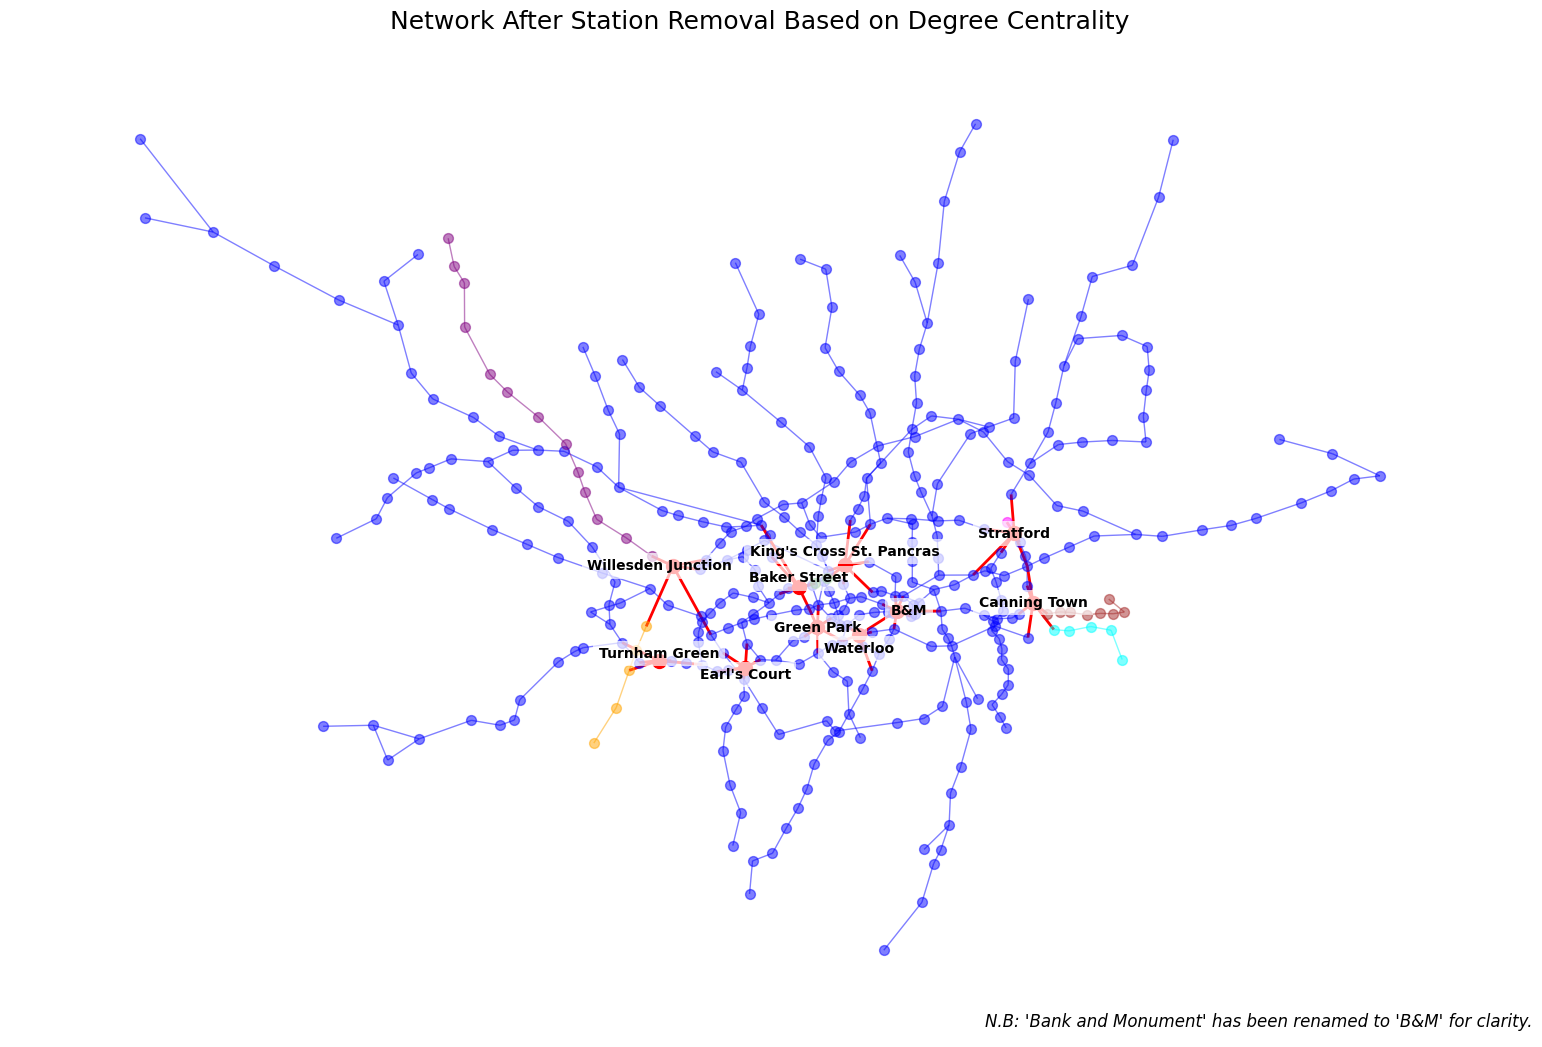

In [ ]:
#Plot stations after removal - ChatGPT helped a lot!
import matplotlib.patheffects as path_effects
import itertools

plt.figure(figsize=(15, 10))

# Define colors for the connected components using a colormap
# This creates a list of colors from the 'tab10' colormap
num_components = len(list(nx.connected_components(G_deg_rem)))
colors = plt.cm.tab10(range(num_components))

# Assign colors to connected components
subgraph_colors = {}
for subgraph, color in zip(nx.connected_components(G_deg_rem), colors):
    for node in subgraph:
        subgraph_colors[node] = color

# Draw each subgraph in a different color
for subgraph, color in zip(nx.connected_components(G_deg_rem), itertools.cycle(['blue', 'green', 'purple', 'orange', 'brown', 'magenta', 'cyan'])):
    nx.draw(G_deg_rem.subgraph(subgraph), pos, with_labels=False, node_size=50, edge_color=color, node_color=color, alpha=0.5)

# Draw removed nodes in red
nx.draw_networkx_nodes(G, pos, nodelist=removed_nodes, node_color="red", node_size=100)

# Draw removed edges in red
nx.draw_networkx_edges(G, pos, edgelist=removed_edges, edge_color="red", width=2)

label_offsets = {
    "Westminster": (0, -600),
    "Leicester Square": (0, -700),
    "Earl's Court": (0, -300),
    "Turnham Green": (0, 300),
    "King's Cross St. Pancras": (0, 600),
    "Baker Street": (0, 400),
    "Willesden Junction": (-650, 0),
    "Bank and Monument": (600, 0),
    "Waterloo": (0, -600)
}

for node in removed_nodes:
    x, y = pos[node]
    label_text = "B&M" if node == "Bank and Monument" else node

    # Apply offset if node is in label_offsets
    x_offset, y_offset = label_offsets.get(node, (0, 0))
    text = plt.text(
        x + x_offset, y + y_offset, label_text, fontsize=10, fontweight="bold", color="black",
        ha="center", va="center", bbox=dict(facecolor="white", edgecolor="none", alpha=0.7))

plt.axis('off')
plt.title("Network After Station Removal Based on Degree Centrality", fontsize=18)
plt.figtext(0.65, 0.01, "N.B: 'Bank and Monument' has been renamed to 'B&M' for clarity.", ha="left", fontsize=12, fontstyle="italic")

plt.tight_layout()
plt.show()

## Eigenvector Centrality

In [ ]:
G_eig_rem = G.copy()

#Set up initial variables
start_lcc = lcc_size(G)
stations_removed = 0
station_removed = 'N/A'
proportion_lcc = 100
num_components = nx.number_connected_components(G)

removed_nodes = []
removed_edges = []

#Initialise dataframe
col_names = ['stations_removed', 'station_removed', 'num_components', 'size_of_lcc', 'proportion_lcc']
results_eig = pd.DataFrame(columns=col_names)
results_eig.loc[0] = [stations_removed, station_removed, num_components, start_lcc, proportion_lcc]

#Sequentially remove nodes based on eigenvector centrality:
for i in range(10):
  #Calculate eigenvector centrality:
  eig_centrality = nx.eigenvector_centrality(G_eig_rem, max_iter=10000)
  nx.set_node_attributes(G_eig_rem, eig_centrality, 'eigenvector_centrality')
  df = pd.DataFrame(index=G_eig_rem.nodes())
  df['eigenvector_centrality'] = pd.Series(nx.get_node_attributes(G_eig_rem, 'eigenvector_centrality'))
  df_sorted = df.sort_values(["eigenvector_centrality"], ascending=False)

  #Find station with the highest centrality
  row = df_sorted.iloc[0]
  node_to_remove = row.name
  #Store nodes and edges for plotting
  removed_nodes.append(node_to_remove)
  removed_edges.extend(list(G_eig_rem.edges(node_to_remove)))

  G_eig_rem.remove_node(node_to_remove)

  #Calculate metrics
  stations_removed += 1
  station_removed = node_to_remove
  num_components= nx.number_connected_components(G_eig_rem)
  size_of_lcc = lcc_size(G_eig_rem)
  current_size = G_eig_rem.number_of_nodes()
  proportion_lcc = round(size_of_lcc / current_size * 100, 2)

  #Add to dataframe
  results_eig.loc[i+1] = [stations_removed, station_removed, num_components, size_of_lcc, proportion_lcc]

results_eig

,stations_removed,station_removed,num_components,size_of_lcc,proportion_lcc
0,0,N/A,1,387,100.00
1,1,Green Park,1,386,100.00
2,2,Bank and Monument,1,385,100.00
3,3,Baker Street,1,384,100.00
4,4,West Ham,1,383,100.00
5,5,Earl's Court,1,382,100.00
6,6,King's Cross St. Pancras,2,379,99.48
7,7,Leicester Square,2,378,99.47
8,8,Waterloo,2,377,99.47
9,9,Turnham Green,2,376,99.47


<ipython-input-52-11b50ca3b4af>:43: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


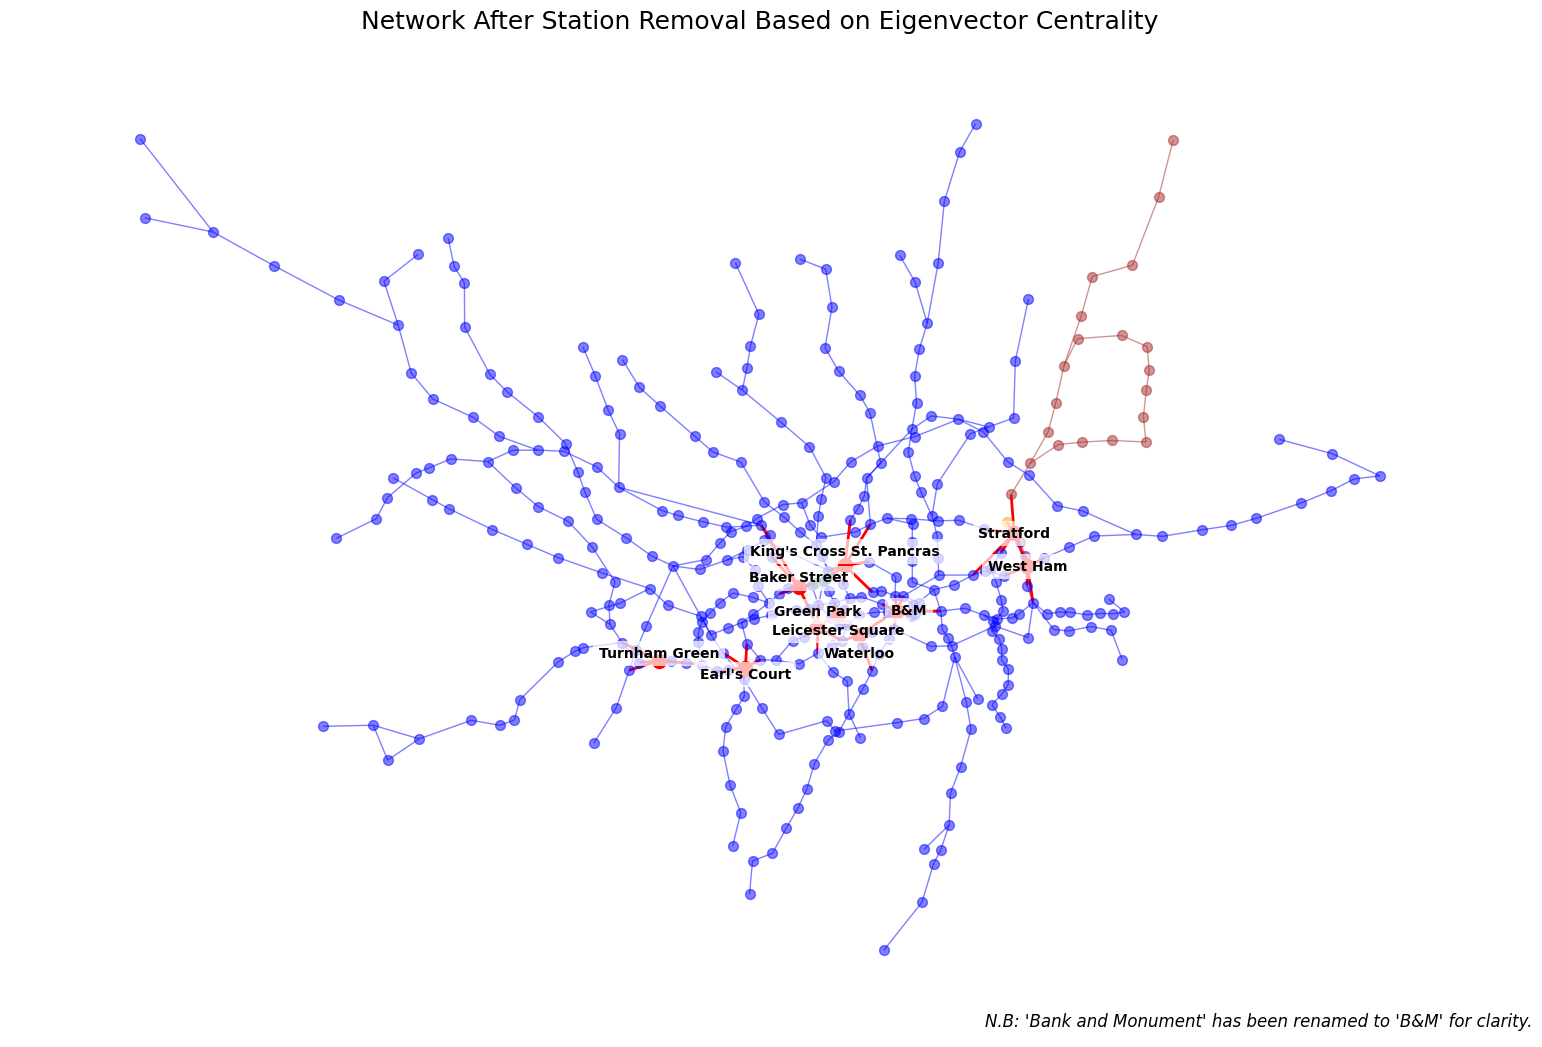

In [ ]:
plt.figure(figsize=(15, 10))

subgraph_colors = {}
for subgraph, color in zip(nx.connected_components(G_eig_rem), colors):
    for node in subgraph:
        subgraph_colors[node] = color

# Draw each subgraph in a different color
for subgraph, color in zip(nx.connected_components(G_eig_rem), itertools.cycle(['blue', 'green', 'purple', 'orange', 'brown', 'pink', 'cyan'])):
    nx.draw(G_eig_rem.subgraph(subgraph), pos, with_labels=False, node_size=50, edge_color=color, node_color=color, alpha=0.5)

# Draw removed nodes in red
nx.draw_networkx_nodes(G, pos, nodelist=removed_nodes, node_color="red", node_size=100)

# Draw removed edges in red
nx.draw_networkx_edges(G, pos, edgelist=removed_edges, edge_color="red", width=2)

label_offsets = {
    "Westminster": (0, -600),
    "Leicester Square": (0, -700),
    "Earl's Court": (0, -300),
    "Turnham Green": (0, 300),
    "King's Cross St. Pancras": (0, 600),
    "Baker Street": (0, 400),
    "Bank and Monument": (600, 0),
    "Waterloo": (0, -800),
    "Green Park": (0, 700)
}

for node in removed_nodes:
    x, y = pos[node]
    label_text = "B&M" if node == "Bank and Monument" else node

    # Apply offset if node is in label_offsets
    x_offset, y_offset = label_offsets.get(node, (0, 0))
    text = plt.text(
        x + x_offset, y + y_offset, label_text, fontsize=10, fontweight="bold", color="black",
        ha="center", va="center", bbox=dict(facecolor="white", edgecolor="none", alpha=0.7))

plt.axis('off')
plt.title("Network After Station Removal Based on Eigenvector Centrality", fontsize=18)
plt.figtext(0.65, 0.01, "N.B: 'Bank and Monument' has been renamed to 'B&M' for clarity.", ha="left", fontsize=12, fontstyle="italic")
plt.tight_layout()
plt.show()

## Betweenness Centrality

In [ ]:
G_bet_rem = G.copy()

#Set up initial variables
start_lcc = lcc_size(G)
stations_removed = 0
station_removed = 'N/A'
proportion_lcc = 100
num_components = nx.number_connected_components(G)

removed_nodes = []
removed_edges = []

#Initialise dataframe
col_names = ['stations_removed', 'station_removed', 'num_components', 'size_of_lcc', 'proportion_lcc']
results_bet = pd.DataFrame(columns=col_names)
results_bet.loc[0] = [stations_removed, station_removed, num_components, start_lcc, proportion_lcc]

#Sequentially remove nodes based on betweenness centrality:
for i in range(10):
  #Calculate betweenness centrality:
  betweenness_centrality = nx.betweenness_centrality(G_bet_rem)
  nx.set_node_attributes(G_bet_rem, betweenness_centrality, 'betweenness_centrality')
  df = pd.DataFrame(index=G_bet_rem.nodes())
  df['betweenness_centrality'] = pd.Series(nx.get_node_attributes(G_bet_rem, 'betweenness_centrality'))
  df_sorted = df.sort_values(["betweenness_centrality"], ascending=False)

  #Find station with the highest centrality
  row = df_sorted.iloc[0]
  node_to_remove = row.name

  # Store removed nodes and edges for plotting
  removed_nodes.append(node_to_remove)
  removed_edges.extend(list(G_bet_rem.edges(node_to_remove)))

  G_bet_rem.remove_node(node_to_remove)

  #Calculate metrics
  stations_removed += 1
  station_removed = node_to_remove
  num_components= nx.number_connected_components(G_bet_rem)
  size_of_lcc = lcc_size(G_bet_rem)
  current_size = G_bet_rem.number_of_nodes()
  proportion_lcc = round(size_of_lcc / current_size * 100, 2)

  #Add to dataframe
  results_bet.loc[i+1] = [stations_removed, station_removed, num_components, size_of_lcc, proportion_lcc]

results_bet
#Sharp drop for Canada Water is becuase the Western tube network becomes entirely disconnected from the right

,stations_removed,station_removed,num_components,size_of_lcc,proportion_lcc
0,0,N/A,1,387,100.00
1,1,King's Cross St. Pancras,1,386,100.00
2,2,Waterloo,1,385,100.00
3,3,Bank and Monument,1,384,100.00
4,4,West Hampstead,1,383,100.00
5,5,Canada Water,2,224,58.64
6,6,Earl's Court,2,223,58.53
7,7,Shepherd's Bush,3,194,51.05
8,8,Euston,4,171,45.12
9,9,Baker Street,5,168,44.44


<ipython-input-54-fffbf3f40743>:37: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


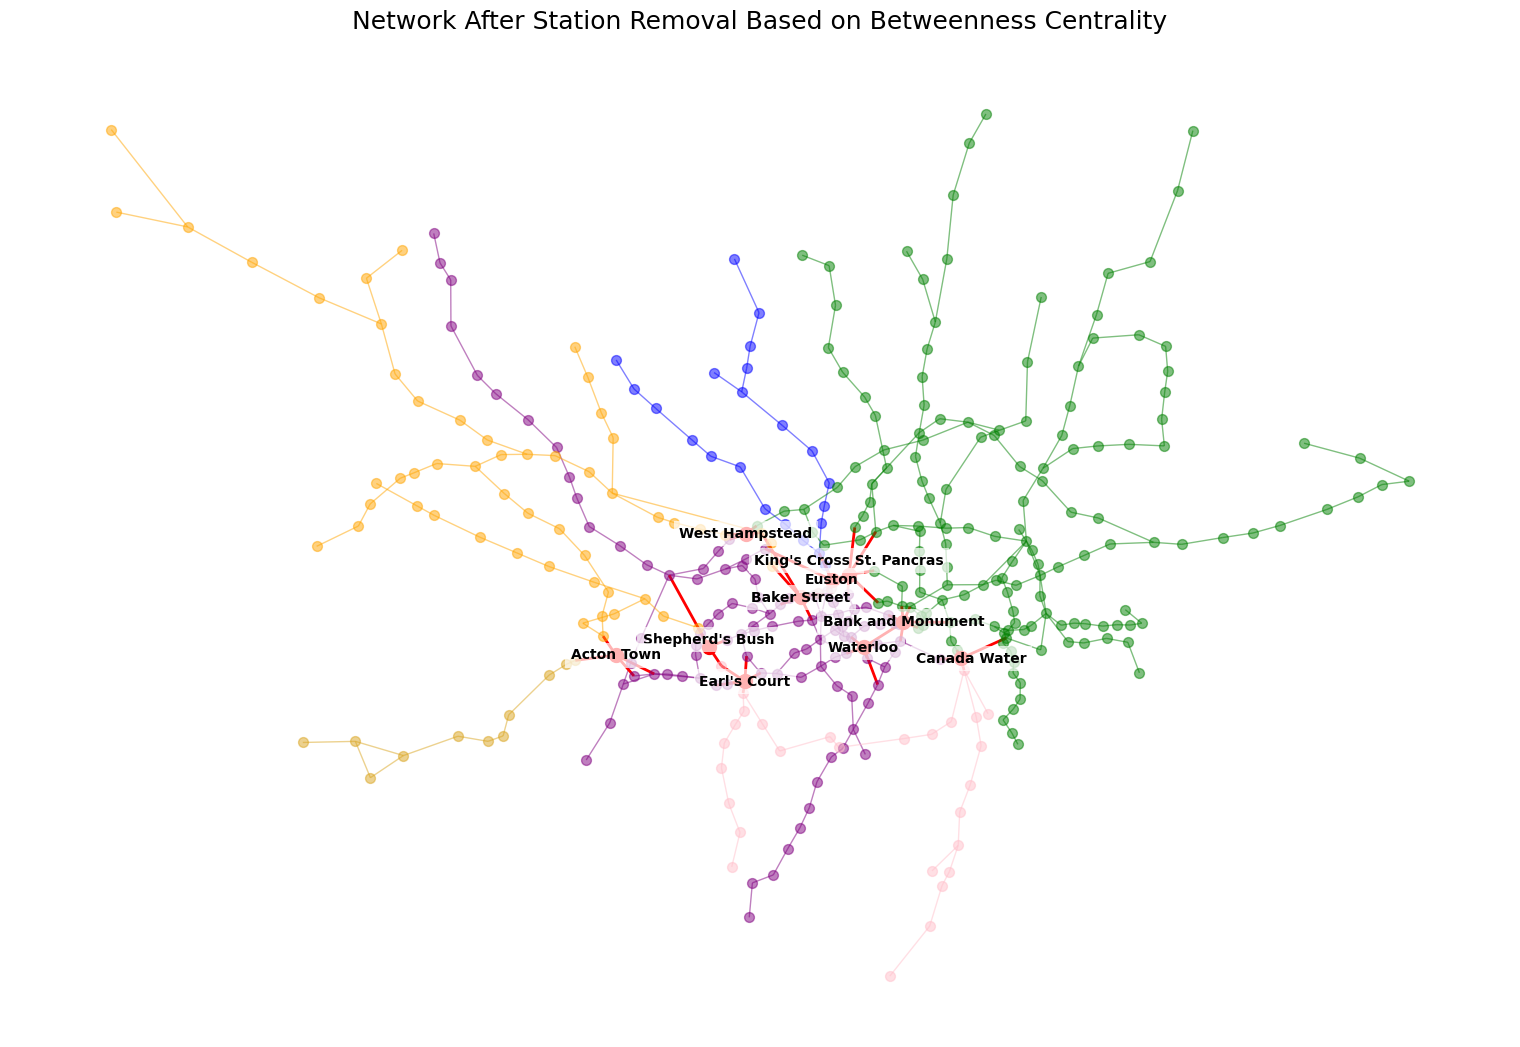

In [ ]:
plt.figure(figsize=(15, 10))

# Assign colors to connected components
subgraph_colors = {}
for subgraph, color in zip(nx.connected_components(G_bet_rem), colors):
    for node in subgraph:
        subgraph_colors[node] = color

# Draw each subgraph in a different color
for subgraph, color in zip(nx.connected_components(G_bet_rem), itertools.cycle(['blue', 'green', 'purple', 'orange', 'brown', 'pink', 'goldenrod'])):
    nx.draw(G_bet_rem.subgraph(subgraph), pos, with_labels=False, node_size=50, edge_color=color, node_color=color, alpha=0.5)

# Draw removed nodes in red
nx.draw_networkx_nodes(G, pos, nodelist=removed_nodes, node_color="red", node_size=100)

# Draw removed edges in red
nx.draw_networkx_edges(G, pos, edgelist=removed_edges, edge_color="red", width=2)

# Add labels for removed nodes with white background

label_offsets = {
    "King's Cross St. Pancras": (0, 600),
    "Canada Water": (500, 0),
    "Shepherd's Bush": (0, 300)}

for node in removed_nodes:
    x, y = pos[node]

    # Apply offset if node is in label_offsets
    x_offset, y_offset = label_offsets.get(node, (0, 0))
    text = plt.text(
        x + x_offset, y + y_offset, node, fontsize=10, fontweight="bold", color="black",
        ha="center", va="center", bbox=dict(facecolor="white", edgecolor="none", alpha=0.7))

plt.axis('off')
plt.title("Network After Station Removal Based on Betweenness Centrality", fontsize=18)
plt.tight_layout()
plt.show()

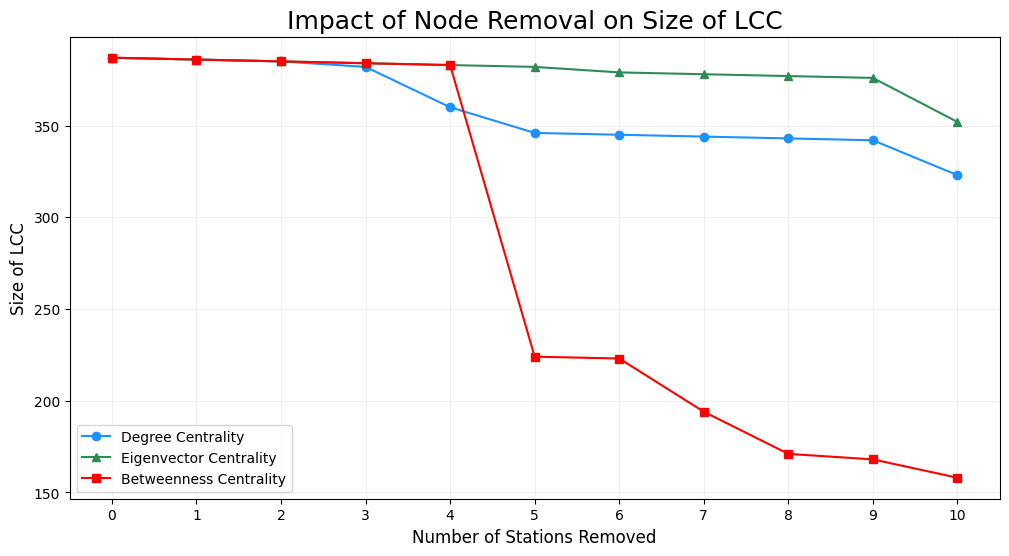

In [ ]:
#Comparing results
plt.figure(figsize=(12, 6))

plt.plot(results_deg['stations_removed'], results_deg['size_of_lcc'],
         marker='o', linestyle='-', color='dodgerblue', label='Degree Centrality')
plt.plot(results_eig['stations_removed'], results_eig['size_of_lcc'],
         marker='^', linestyle='-', color='seagreen',label='Eigenvector Centrality')
plt.plot(results_bet['stations_removed'], results_bet['size_of_lcc'],
         marker='s', linestyle='-', color='red', label='Betweenness Centrality')

plt.xlabel("Number of Stations Removed", fontsize=12)
plt.ylabel("Size of LCC", fontsize=12)
plt.title("Impact of Node Removal on Size of LCC", fontsize=18)
plt.grid(True, linestyle='-', alpha=0.2)
plt.legend()
plt.xticks(range(0, 11))
plt.show()

#Very similar - it's likely other measures would be a better indication of resilience and efficiency

#Eig actually less disruptive than deg - maybe because if a node is connected to lots of other important nodes, these adjacent nodes will actually help increase connectivity? i.e. the nodes removed are less broker-ish

## Weighted Network

Centrality calculations will not consider directions - it is just indications of the *overall* flow at a station.

### Weighted Degree Centrality

In [ ]:
#We are taking flows (rather than inverse flows) as more people = more important

w_degree = nx.degree(G, weight='flows')
nx.set_node_attributes(G,dict(w_degree),'w_degree')

#Degree (rather than degree centrality) was computed as networkx doesn't have the option to weight degree centrality

### Weighted Eigenvector Centrality

In [ ]:
#We are taking flows (rather than inverse flows) as more people = more important

w_eigen = nx.eigenvector_centrality(G, max_iter=10000, weight='flows')
nx.set_node_attributes(G,dict(w_eigen),'w_eigen')

### Weighted Betweenness Centrality

In [ ]:
#We are taking flows (rather than inverse flows) as more people = more important

w_between = nx.betweenness_centrality(G, weight='flows')
nx.set_node_attributes(G,dict(w_between),'w_between')

In [ ]:
#Let's try with inverse flows!! As more people = more important so we need lower weights for shortest paths

w_between_inv = nx.betweenness_centrality(G, weight='inverse_flows')
nx.set_node_attributes(G,dict(w_between_inv),'w_between_inv')

### Results

In [ ]:
dfw = pd.DataFrame(index=G.nodes())
dfw['w_degree'] = pd.Series(nx.get_node_attributes(G, 'w_degree'))
dfw['w_eigen'] = pd.Series(nx.get_node_attributes(G, 'w_eigen'))
dfw['w_between'] = pd.Series(nx.get_node_attributes(G, 'w_between'))
dfw['w_between_inv'] = pd.Series(nx.get_node_attributes(G, 'w_between_inv'))

In [ ]:
#Top weighted degree
dfw_sorted_deg = dfw.sort_values('w_degree', ascending=False)
dfw_sorted_deg.head(10)

,w_degree,w_eigen,w_between,w_between_inv
Bank and Monument,675271,0.487247,0.082323,0.493520
Green Park,610752,0.345296,0.018236,0.583056
Waterloo,543316,0.533600,0.095889,0.377956
King's Cross St. Pancras,480953,0.011742,0.099482,0.229796
Westminster,424741,0.420493,0.014925,0.345845
Victoria,406074,0.186921,0.005356,0.279618
Euston,390224,0.019857,0.110100,0.296629
Oxford Circus,319340,0.132132,0.133477,0.281946
Liverpool Street,316166,0.199408,0.053334,0.301245
Baker Street,305681,0.027302,0.122186,0.253994


In [ ]:
#Top weighted eigenvector centrality
dfw_sorted_eig = dfw.sort_values('w_eigen', ascending=False)
dfw_sorted_eig.head(10)

,w_degree,w_eigen,w_between,w_between_inv
Waterloo,543316,0.533600,0.095889,0.377956
Bank and Monument,675271,0.487247,0.082323,0.493520
Westminster,424741,0.420493,0.014925,0.345845
Green Park,610752,0.345296,0.018236,0.583056
Liverpool Street,316166,0.199408,0.053334,0.301245
Victoria,406074,0.186921,0.005356,0.279618
London Bridge,236051,0.159330,0.003728,0.149142
Oxford Circus,319340,0.132132,0.133477,0.281946
Moorgate,228508,0.122185,0.051719,0.093829
Bond Street,243785,0.110457,0.030254,0.259511


In [ ]:
#Top weighted betweenness
dfw_sorted_bet = dfw.sort_values('w_between', ascending=False)
dfw_sorted_bet.head(10)

,w_degree,w_eigen,w_between,w_between_inv
West Hampstead,50973,3.043900e-04,0.358145,0.039446
Gospel Oak,14998,2.161577e-09,0.312294,0.005222
Finchley Road & Frognal,14165,5.328085e-06,0.288823,0.015288
Hampstead Heath,14425,9.798782e-08,0.288083,0.010228
Willesden Junction,98909,5.295973e-07,0.245946,0.077505
Whitechapel,67500,1.818655e-03,0.241343,0.012503
Brondesbury,19097,7.225385e-06,0.219312,0.004185
Brondesbury Park,19234,1.785683e-07,0.217899,0.000310
Kensal Rise,20119,1.854411e-08,0.216526,0.001279
West Ham,164826,1.596767e-03,0.205612,0.158119


In [ ]:
#Top inverse weighted betweenness
dfw_sorted_bet_inv = dfw.sort_values('w_between_inv', ascending=False)
dfw_sorted_bet_inv.head(10)

,w_degree,w_eigen,w_between,w_between_inv
Green Park,610752,0.345296,0.018236,0.583056
Bank and Monument,675271,0.487247,0.082323,0.493520
Waterloo,543316,0.533600,0.095889,0.377956
Westminster,424741,0.420493,0.014925,0.345845
Liverpool Street,316166,0.199408,0.053334,0.301245
Euston,390224,0.019857,0.110100,0.296629
Bethnal Green,263990,0.074822,0.017065,0.294422
Oxford Circus,319340,0.132132,0.133477,0.281946
Victoria,406074,0.186921,0.005356,0.279618
Mile End,258308,0.024770,0.178534,0.273723


### Creating a Directed Graph for OD Calculations

In [ ]:
G_di = nx.DiGraph()  #Create an empty DiGraph

#Add nodes - with coords and lines data
for node, data in G.nodes(data=True):
    G_di.add_node(node, coords=data.get('coords'), lines=data.get('lines'))

#Add edges in both directions, keeping only length and line name
#Adapted from Practical 5, with help from ChatGPT
for u, v, data in G.edges(data=True):
    edge_data = {key: data[key] for key in ['length', 'line_name'] if key in data}

    # Add edge in original direction
    G_di.add_edge(u, v, **edge_data)

    # Add reverse edge if it doesn't exist
    if not G_di.has_edge(v, u):
        G_di.add_edge(v, u, **edge_data)

print(G)
print(G_di) #Numbers look good

Graph with 387 nodes and 451 edges
DiGraph with 387 nodes and 902 edges


In [ ]:
#In order to add flows, we need to remove Battersea Park from the flow data
london_OD_AMpeak_new = london_OD_AMpeak[
    (london_OD_AMpeak['station_origin'] != 'Battersea Park') &
    (london_OD_AMpeak['station_destination'] != 'Battersea Park')].copy()

In [ ]:
#Add flows (following Practical 5)

#create a dictionary to store flows for all edges
flows_d = {(u,v): 0 for u,v in G_di.edges()}
#This is adding the number of flows for each OD journey to all of the edges on the shortest path

#calculate shortest paths for all flows and add data to dict
for i, row in london_OD_AMpeak_new.iterrows():
    source = row.station_origin
    target = row.station_destination

    #get shortest path
    path = nx.dijkstra_path(G_di, source, target)

    #our path is a list of nodes, we need to turn this to a list of edges
    path_edges = list(zip(path,path[1:]))

    #add flows to our dict
    for u,v in path_edges:
        try:
            flows_d[(u,v)] += row.flows
        except:
            flows_d[(v,u)] += row.flows

#set this as a network attribute
nx.set_edge_attributes(G_di, flows_d, 'flows')

### Find Stations with Largest OD Flow

In [ ]:
#Find max flows in london_OD_AMpeak
london_OD_AMpeak[london_OD_AMpeak['flows'] == london_OD_AMpeak['flows'].max()]

,station_origin,station_destination,flows
55995,Waterloo,Bank and Monument,15946


In [ ]:
#Check flows from B&M to Waterloo
london_OD_AMpeak[(london_OD_AMpeak['station_origin'] == 'Bank and Monument') & (london_OD_AMpeak['station_destination'] == 'Waterloo')]

,station_origin,station_destination,flows
2837,Bank and Monument,Waterloo,1561


In [ ]:
#Finding number affected

#Report number of people travelling from Waterloo to Bank & Monument

#But we also need:
  # Sum of people boarding at Waterloo
  # Sum of people exiting at Waterloo
  # Sum of people transferring at Waterloo

#Sum of people boarding at Waterloo
waterloo_boarding = london_OD_AMpeak[london_OD_AMpeak['station_origin'] == 'Waterloo']['flows'].sum()

#Sum of people exiting at Waterloo
waterloo_exiting = london_OD_AMpeak[london_OD_AMpeak['station_destination'] == 'Waterloo']['flows'].sum()

print(f'Sum of people boading at Waterloo: {waterloo_boarding}')
print(f'Sum of people exiting at Waterloo: {waterloo_exiting}')

Sum of people boading at Waterloo: 67372
Sum of people exiting at Waterloo: 23466


In [ ]:
#To find people switching lines at Waterloo
#We need to find all the shortest paths which involve transfers between lines at Waterloo

#To do:
  #For each OD pair, find whether the shortest path goes through Waterloo
  #Check whether the line switches immediately after
  #Calculate the total flows on these journeys where there is a transfer here

def check_transfer_at_waterloo(G, origin, destination):
    previous_line = None
    transfer_at_waterloo = False

    #Skip if the origin or destination is Waterloo
    if origin == "Waterloo" or destination == "Waterloo":
        return False

    #Find the shortest path between the origin and destination
    shortest_path = nx.dijkstra_path(G, origin, destination)

    #Iterate through the path and check for line switches at Waterloo - ChatGPT helped here
    for i in range(len(shortest_path) - 1):
        u, v = shortest_path[i], shortest_path[i + 1]

        # Ensure the edge has the 'line_name' attribute
        if G.has_edge(u, v) and "line_name" in G[u][v]:
            line_name = G[u][v]["line_name"]

            # Check if the current station is Waterloo and if the line is switching
            if (previous_line is not None and previous_line != line_name) and (u == "Waterloo" or v == "Waterloo"):
                transfer_at_waterloo = True
            # Update the previous line
            previous_line = line_name

    return transfer_at_waterloo

#Sum flows where there is a line change at Waterloo
def calculate_flows_with_transfers_at_waterloo(OD_pairs_df, G):

    total_flow_at_waterloo = 0

    for index, row in OD_pairs_df.iterrows():
        origin = row['station_origin']
        destination = row['station_destination']
        flow = row['flows']

        # Exclude pairs where the origin or destination is Waterloo
        if origin == "Waterloo" or destination == "Waterloo":
            continue

        if check_transfer_at_waterloo(G, origin, destination):
            total_flow_at_waterloo += flow

    return total_flow_at_waterloo

In [ ]:
#Calculate transfers at Waterloo
#This assumes people take the topologically shortest paths
waterloo_transfers_sum = calculate_flows_with_transfers_at_waterloo(london_OD_AMpeak_new, G_di)
print(f"Total flow involving transfers at Waterloo: {waterloo_transfers_sum}")

Total flow involving transfers at Waterloo: 216020


In [ ]:
#Find sum of people affected
total_affected = waterloo_boarding + waterloo_exiting + waterloo_transfers_sum
print(f'Total number of people affected: {total_affected}')

Total number of people affected: 306858


In [ ]:
#Find proportion of people affected out of all flows
round(total_affected / london_OD_AMpeak_new['flows'].sum() * 100, 2)

np.float64(20.34)

### Getting from Waterloo to Bank, if Waterloo is Shut

In [ ]:
#First, we need to get the coordinates in ESPG4326 format - ChatGPT showed how to use the coordinate transformer
import pyproj

#Define the coordinate transformer
transformer = pyproj.Transformer.from_crs("EPSG:27700", "EPSG:4326", always_xy=True)

#Create an empty graph to add coordinates to
G_wgs84 = nx.Graph()

#Loop through each node in the original graph and convert coordinates
for node, data in G.nodes(data=True):
    if "coords" in data:
        bng_x, bng_y = data["coords"]
        lon, lat = transformer.transform(bng_x, bng_y)
        new_data = {**data, "coords": (lat, lon)}
        G_wgs84.add_node(node, **new_data)

#Copy edges over
G_wgs84.add_edges_from(G.edges(data=True))

In [ ]:
print(G_wgs84)
G_wgs84.nodes['Waterloo'] #looks good

Graph with 387 nodes and 451 edges


{'coords': (51.50305575891469, -0.11438192841168801),
 'lines': ['Waterloo & City', 'Northern', 'Bakerloo', 'Jubilee'],
 'top_degree': 6,
 'top_degree_norm': 0.015544041450777202,
 'top_eigen': 0.24650985008175877,
 'top_between': 0.20982339785986884,
 'w_degree': 543316,
 'w_eigen': 0.5336003149804684,
 'w_between_inv': 0.37795572303344327,
 'w_between': 0.09588856739115807}

In [ ]:
#Now we need to extract the street network for this area of London

#Extract coords from nodes
waterloo_coords = G_wgs84.nodes['Waterloo']['coords']

#Define a buffer of stations I want to retrieve around Waterloo - let's say 2.5km, even though this will be too high
buffer = 2500

#Extract the road network for 2.5km around Waterloo station
G_road = ox.graph_from_point(waterloo_coords, dist=buffer, network_type='drive')

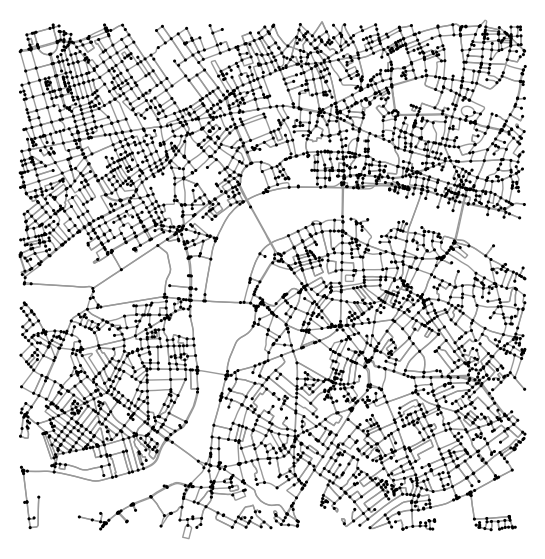

In [ ]:
#Quick plot
fig, ax = plt.subplots(figsize=(12,7))
fig, ax = ox.plot_graph(G_road,
                        node_color='k',
                        node_size = 5,
                        ax=ax)

In [ ]:
#Find bounding box of street network
waterloo_bbox = ox.utils_geo.bbox_from_point(waterloo_coords, dist=buffer)
west, south, east, north = waterloo_bbox

#Find all stations in this bounding box
stations_in_bbox = []

for node, data in G_wgs84.nodes(data=True):
    if "coords" in data:
        lat, lon = data["coords"]
        if south <= lat <= north and west <= lon <= east:
            stations_in_bbox.append({"station": node, "lon": lon, "lat": lat})

potential_stations = pd.DataFrame(stations_in_bbox)

In [ ]:
#Append the nearest street node to all of these stations
potential_stations['nearest_node'] = ox.nearest_nodes(G_road, potential_stations['lon'], potential_stations['lat'])

#Find Waterloo nearest node, then remove waterloo
waterloo_node = potential_stations[potential_stations['station'] == 'Waterloo']['nearest_node'].iloc[0]
potential_stations = potential_stations[potential_stations['nearest_node'] != waterloo_node]

#Find the distance between each station and Waterloo
potential_stations['distance'] = potential_stations.apply(lambda row: nx.shortest_path_length(G_road, row['nearest_node'], waterloo_node, weight='length'), axis=1)


In [ ]:
#Calculate walking time in seconds, assuming someone walks 1.4m/s (Liu et al., 2023)
potential_stations['walking_time'] = potential_stations['distance'] / 1.4

In [ ]:
#Remove stations where the walking time is longer than the walk to Bank and Monument
bank_walking_time = potential_stations[potential_stations['station'] == 'Bank and Monument']['walking_time'].iloc[0]
potential_stations = potential_stations[potential_stations['walking_time'] < bank_walking_time]
potential_stations.shape

(30, 6)

In [ ]:
potential_stations

,station,lon,lat,nearest_node,distance,walking_time
2,London Bridge,-0.089661,51.505019,7982777191,2111.300961,1508.072115
3,Borough,-0.093436,51.501092,2217388387,1946.110556,1390.078969
4,Elephant & Castle,-0.100570,51.495382,3880960401,1572.649223,1123.320874
5,Kennington,-0.105578,51.488817,264797751,2117.918771,1512.799122
6,Oval,-0.112394,51.481828,8982713135,2571.396640,1836.711886
7,Charing Cross,-0.127387,51.507334,26671718,1549.170799,1106.550571
8,Embankment,-0.122602,51.507013,1139318692,1452.807771,1037.719836
11,Goodge Street,-0.134383,51.520513,11863145,3110.289459,2221.635328
12,Tottenham Court Road,-0.131037,51.515982,21665026,2680.900387,1914.928848
13,Leicester Square,-0.128515,51.511221,107790,2030.011490,1450.008207


In [ ]:
#Now we need to calculate the shortest path from each of these stations to Bank on the tube network
tube_stops_to_bank = []

# Loop through each station in the DataFrame
for index, row in potential_stations.iterrows():
    origin = row['station']
    destination = 'Bank and Monument'
    shortest_path = nx.dijkstra_path(G, origin, destination)
    tube_stops_to_bank.append(len(shortest_path))

#Add this to dataframe
potential_stations['tube_stops_to_bank'] = tube_stops_to_bank

potential_stations.head()

<ipython-input-78-1f3a3575f285>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  potential_stations['tube_stops_to_bank'] = tube_stops_to_bank


,station,lon,lat,nearest_node,distance,walking_time,tube_stops_to_bank
2,London Bridge,-0.089661,51.505019,7982777191,2111.300961,1508.072115,2
3,Borough,-0.093436,51.501092,2217388387,1946.110556,1390.078969,3
4,Elephant & Castle,-0.100570,51.495382,3880960401,1572.649223,1123.320874,4
5,Kennington,-0.105578,51.488817,264797751,2117.918771,1512.799122,3
6,Oval,-0.112394,51.481828,8982713135,2571.396640,1836.711886,4


In [ ]:
#Now let's calculate the shortest path in terms of distance
tube_length_to_bank = []

# Loop through each station in the DataFrame
for index, row in potential_stations.iterrows():
    origin = row['station']
    destination = 'Bank and Monument'
    shortest_path = nx.dijkstra_path_length(G, origin, destination, weight='length')
    tube_length_to_bank.append(shortest_path)

#Add this to dataframe
potential_stations['tube_journey_distance'] = tube_length_to_bank

potential_stations.head()

<ipython-input-79-9d331d9e1d15>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  potential_stations['tube_journey_distance'] = tube_length_to_bank


,station,lon,lat,nearest_node,distance,walking_time,tube_stops_to_bank,tube_journey_distance
2,London Bridge,-0.089661,51.505019,7982777191,2111.300961,1508.072115,2,886.711434
3,Borough,-0.093436,51.501092,2217388387,1946.110556,1390.078969,3,1401.292286
4,Elephant & Castle,-0.100570,51.495382,3880960401,1572.649223,1123.320874,4,2222.411778
5,Kennington,-0.105578,51.488817,264797751,2117.918771,1512.799122,3,3061.964052
6,Oval,-0.112394,51.481828,8982713135,2571.396640,1836.711886,4,3977.109373


In [ ]:
#Let's calculate the amount of time on the tube, assuming it travels uniformly at 33km/h (https://www.bbc.co.uk/news/science-environment-34334794)
potential_stations['tube_time'] = potential_stations['tube_journey_distance'] / 9.1667

#Let's add a 1 minute pause at stops (60 seconds)
potential_stations['tube_pauses'] = (potential_stations['tube_stops_to_bank'] - 2) * 60

potential_stations['total_tube_time'] = potential_stations['tube_time'] + potential_stations['tube_pauses'] + 300 #Adding 5 mins for entering network

potential_stations.head()

<ipython-input-80-8703c7cd04f4>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  potential_stations['tube_time'] = potential_stations['tube_journey_distance'] / 9.1667
<ipython-input-80-8703c7cd04f4>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  potential_stations['tube_pauses'] = (potential_stations['tube_stops_to_bank'] - 2) * 60
<ipython-input-80-8703c7cd04f4>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

,station,lon,lat,nearest_node,distance,walking_time,tube_stops_to_bank,tube_journey_distance,tube_time,tube_pauses,total_tube_time
2,London Bridge,-0.089661,51.505019,7982777191,2111.300961,1508.072115,2,886.711434,96.731805,0,396.731805
3,Borough,-0.093436,51.501092,2217388387,1946.110556,1390.078969,3,1401.292286,152.867693,60,512.867693
4,Elephant & Castle,-0.100570,51.495382,3880960401,1572.649223,1123.320874,4,2222.411778,242.444040,120,662.444040
5,Kennington,-0.105578,51.488817,264797751,2117.918771,1512.799122,3,3061.964052,334.031227,60,694.031227
6,Oval,-0.112394,51.481828,8982713135,2571.396640,1836.711886,4,3977.109373,433.864899,120,853.864899


In [ ]:
#Let's find total time
potential_stations['total_time'] = potential_stations['walking_time'] + potential_stations['total_tube_time']

#Sort by total time
potential_stations = potential_stations.sort_values(by='total_time', ascending=True)

potential_stations.head(20)

#Remember all timings are in seconds!!
#And timings are likely an underestimate because of no transfer penalties

#But anyway I would recommend Lambeth North - 427.423517 walking time, which is just over 7 min
#Although Westminster may have been preferable if we had accounted for transfer times

<ipython-input-81-f82a14f34db2>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  potential_stations['total_time'] = potential_stations['walking_time'] + potential_stations['total_tube_time']


,station,lon,lat,nearest_node,distance,walking_time,tube_stops_to_bank,tube_journey_distance,tube_time,tube_pauses,total_tube_time,total_time
21,Lambeth North,-0.112313,51.498885,6297799650,598.392923,427.423517,3,3116.578463,339.989141,60,699.989141,1127.412658
27,Westminster,-0.125981,51.500876,10363909455,828.596042,591.854316,3,3393.242667,370.170581,60,730.170581,1322.024897
38,Southwark,-0.105175,51.504079,25475603,1300.096905,928.640646,3,1985.042297,216.549281,60,576.549281,1505.189927
8,Embankment,-0.122602,51.507013,1139318692,1452.807771,1037.719836,3,2784.340462,303.745128,60,663.745128,1701.464964
29,Blackfriars,-0.103166,51.511773,107668,1641.101694,1172.215496,4,1237.736394,135.025297,120,555.025297,1727.240793
4,Elephant & Castle,-0.100570,51.495382,3880960401,1572.649223,1123.320874,4,2222.411778,242.444040,120,662.444040,1785.764913
7,Charing Cross,-0.127387,51.507334,26671718,1549.170799,1106.550571,4,3124.666292,340.871447,120,760.871447,1867.422018
26,St. James's Park,-0.133561,51.499611,12198505,1471.851350,1051.322393,4,3953.980973,431.341810,120,851.341810,1902.664203
3,Borough,-0.093436,51.501092,2217388387,1946.110556,1390.078969,3,1401.292286,152.867693,60,512.867693,1902.946662
2,London Bridge,-0.089661,51.505019,7982777191,2111.300961,1508.072115,2,886.711434,96.731805,0,396.731805,1904.803919
